1.Файл twitter1.csv. Використати опорні вектори
2.Файл lab6-1.txt. а) Знайти та вивести стоп-слова, які присутні у тексті. б) Знайти та вивести всі дієслова, які присутні у тексті. в) Знайти та вивести країни та особи, які присутні у тексті.

## Завантаження файлу у датафрейм та його огляд

In [1]:
import pandas as pd

twitter_df = pd.read_csv('twitter1.csv', header=None)
twitter_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [2]:
twitter_df.shape

(74682, 4)

In [3]:
twitter_df = twitter_df.iloc[:, 2:]
twitter_df.columns = ['Sentiment', 'Tweet']
twitter_df['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

## Видалення зайвої категорії та перевірка на збалансованість

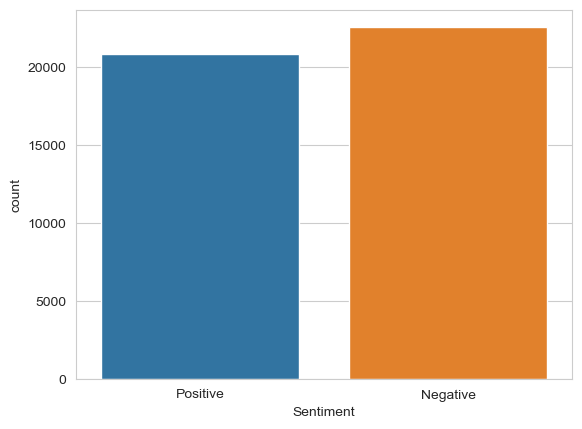

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

twitter_df = twitter_df[twitter_df['Sentiment'] != 'Irrelevant'].reset_index(drop=True)
sns.countplot(x='Sentiment', data=twitter_df, order=['Positive', 'Negative'])
plt.show()

## Видалення пропущених значень та дублікатів

In [5]:
print(twitter_df.duplicated().sum())
twitter_df.isna().sum()

4204


Sentiment      0
Tweet        571
dtype: int64

In [6]:
twitter_df = twitter_df.drop_duplicates().dropna().reset_index(drop=True)
twitter_df.shape

(57485, 2)

## Попередня обробка корпусу та розділення на навчальні й тестові набори

In [7]:
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))
tokenizer = WordPunctTokenizer()


def preprocess_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = tokenizer.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    doc = ' '.join(filtered_tokens)
    return doc

In [8]:
twitter_df['Tweet'] = twitter_df['Tweet'].apply(preprocess_document)
twitter_df.head()

,Sentiment,Tweet
0,Positive,getting borderlands murder
1,Positive,coming borders kill
2,Positive,getting borderlands kill
3,Positive,coming borderlands murder
4,Positive,getting borderlands murder


In [9]:
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_sentiment_labels, test_sentiment_labels = train_test_split(twitter_df['Tweet'],
                                                                                            twitter_df['Sentiment'],
                                                                                            test_size=0.2,
                                                                                            stratify=twitter_df[
                                                                                                'Sentiment'],
                                                                                            random_state=1234)

## Векторизація корпусу з використанням tf-idf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
tfidf_train_features = tfidf_vectorizer.fit_transform(train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)

## SVC для аналізу настроїв

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svc = SVC(max_iter=2500, random_state=1234)
svc.fit(tfidf_train_features, train_sentiment_labels)
predicted_sentiments = svc.predict(tfidf_test_features)
unique_classes = list(set(test_sentiment_labels))
print(classification_report(test_sentiment_labels, predicted_sentiments, labels=unique_classes))

/Users/kyryl/anaconda3/envs/TextAnalysis/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      4247
    Positive       0.91      0.90      0.90      3828
     Neutral       0.89      0.88      0.89      3422

    accuracy                           0.90     11497
   macro avg       0.90      0.90      0.90     11497
weighted avg       0.90      0.90      0.90     11497


## TextBlob для аналізу настроїв

In [12]:
from textblob import TextBlob


def get_sentiment(tweet):
    score = TextBlob(tweet).sentiment.polarity
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'

    return 'Positive'


predicted_sentiments = test_corpus.apply(get_sentiment)
print(classification_report(test_sentiment_labels, predicted_sentiments, labels=unique_classes))

              precision    recall  f1-score   support

    Negative       0.57      0.47      0.52      4247
    Positive       0.48      0.65      0.55      3828
     Neutral       0.36      0.30      0.32      3422

    accuracy                           0.48     11497
   macro avg       0.47      0.47      0.46     11497
weighted avg       0.48      0.48      0.47     11497


## Порівнняння SVC та TextBlob на трьох випадкових записах

In [13]:
random_sample = twitter_df.sample(3)
tweets_vectorized = tfidf_vectorizer.transform(random_sample['Tweet'])
true_sentiments = random_sample['Sentiment']
random_sample['Predictions (SVC)'] = svc.predict(tweets_vectorized)
random_sample['Predictions (TextBlob)'] = random_sample['Tweet'].apply(get_sentiment)
random_sample

,Sentiment,Tweet,Predictions (SVC),Predictions (TextBlob)
38269,Negative,yall knows nobody announces fifa youre shit fi...,Negative,Negative
16764,Positive,thank youuu gonna buy level gun fnatic sticker,Positive,Neutral
22059,Neutral,apex legends season boosted launch trailer you...,Neutral,Neutral


## Виведення стоп-слів

In [14]:
import spacy

with open('lab6-1.txt') as file:
    text = file.read()

nlp = spacy.load('en_core_web_sm')
text_nlp = nlp(text)

present_stop_words = set([token.text.lower() for token in text_nlp if token.is_stop and token.is_alpha])

print(present_stop_words)

{'at', 'some', 'but', 'he', 'than', 'the', 'up', 'and', 'they', 'only', 'these', 'after', 'put', 'of', 'their', 'had', 'to', 'just', 'is', 'a', 'were', 'for', 'what', 'us', 'still', 'while', 'down', 'not', 'would', 'are', 'first', 'since', 'in', 'that', 'last', 'been', 'as', 'we', 'part', 'by'}


## Виведення усіх дієслів у тексті

In [15]:
from spacy.symbols import VERB

verbs = {token.lemma_ for token in text_nlp if token.pos == VERB}
print(verbs)

{'rise', 'drive', 'spend', 'include', 'dip', 'fall', 'expect', 'fuel', 'drop', 'give', 'put', 'add', 'exclude', 'see', 'continue', 'jump', 'agree', 'say', 'retain', 'come'}


## Виведення осіб та країн у тексті

In [16]:
import pycountry

countries = {country.name.lower() for country in pycountry.countries}
country_abbreviations = {'usa', 'us', 'uk', 'uae'}
all_countries = countries.union(country_abbreviations)
countries_people = set([token.text for token in text_nlp if
                        (token.ent_type_ == "PERSON") or (
                                token.ent_type_ == "GPE" and token.text.lower() in all_countries)])

print(countries_people)

{'Van', 'Jain', 'Parul', 'Steve', 'Gallagher', 'US', 'Rourke'}
